# Lens model parameters recovery

Assess recovery of true lens model parameters when other are kept fixed at their true value.

In [1]:
import os
import sys
import copy
import time
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as pf
import pysap
import tqdm
import corner
import pickle as pkl

from lenstronomy.Data.psf import PSF
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.ImSim.image_model import ImageModel
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.Util import class_creator
from lenstronomy.Workflow.fitting_sequence import FittingSequence
from lenstronomy.Plots.model_plot import ModelPlot
from lenstronomy.ImSim.image_sparse_solve import ImageSparseFit
from lenstronomy.Plots import chain_plot
from lenstronomy.Util import kernel_util
import lenstronomy.Util.simulation_util as sim_util
import lenstronomy.Util.image_util as image_util
import lenstronomy.Util.util as lenstro_util

from lenstronomy.LightModel.Profiles.starlets import Starlets

from slitronomy.Util.plot_util import nice_colorbar, log_cmap

np.random.seed(118)

n_points = 50

%matplotlib inline

In [2]:
def noise_with_SNR(snr_db, image):
    if np.isinf(snr_db):
        return 0, 0
    sigma = np.linalg.norm(image.flatten(), 2) / snr_db
    noise = sigma * np.random.randn(*image.shape)
    return sigma, noise

In [3]:
lin_scale = lambda x: x
log_scale = lambda x: np.log10(x)
sqrt_scale = lambda x: np.sqrt(x)

In [4]:
# data specifics
num_pix = 99  # cutout pixel size
delta_pix = 0.08  # pixel size in arcsec (area per pixel = deltaPix**2)

psf_fwhm = 0.2  # full width half max of PSF, in delta_pix units
psf_num_pix = 15

(15, 15)


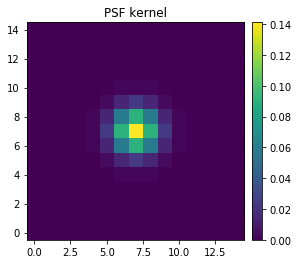

In [5]:
# data specification (coordinates, etc.)
_, _, ra_at_xy_0, dec_at_xy_0, _, _, Mpix2coord, _ \
    = lenstro_util.make_grid_with_coordtransform(numPix=num_pix, deltapix=delta_pix, subgrid_res=1, 
                                                 inverse=False, left_lower=False)

kwargs_data = {
    'ra_at_xy_0': ra_at_xy_0, 'dec_at_xy_0': dec_at_xy_0, 
    'transform_pix2angle': Mpix2coord,
    'image_data': np.zeros((num_pix, num_pix))
}
data_class_tmp = ImageData(**kwargs_data)

# PSF specification
psf_kernel = kernel_util.kernel_gaussian(psf_num_pix, delta_pix, psf_fwhm)
print(psf_kernel.shape)
kwargs_psf = {'psf_type': 'PIXEL', 'kernel_point_source': psf_kernel}
psf_class = PSF(**kwargs_psf)

plt.title("PSF kernel")
im = plt.imshow(psf_class.kernel_point_source, origin='lower')
nice_colorbar(im)
plt.show()

In [6]:
lens_model_list = ['SPEMD', 'SHEAR_GAMMA_PSI']
kwargs_spemd = {'theta_E': 1.8, 'gamma': 2, 'center_x': 0, 'center_y': 0, 'e1': 0.1, 'e2': -0.2}
kwargs_shear = {'gamma_ext': 0.02, 'psi_ext': 0.5, 'ra_0': kwargs_spemd['center_x'], 'dec_0': kwargs_spemd['center_y']}
kwargs_lens = [kwargs_spemd, kwargs_shear]
lens_model_class = LensModel(lens_model_list=lens_model_list)

# list of source light profiles from Galsim (COSMOS galaxy)
galsim_index = 1
snr_data = 500
galsim_data_path = ('../notebooks/data/ring_sims/sims_SNR{}/simring_galsim{}_all.pkl'.format(snr_data, galsim_index))
[data, truth, lens_model] = pkl.load(open(galsim_data_path, 'rb'))
galsim_source_highres = truth['source_galsim_3']
background_rms = 0  # we'll the noise afterwards
galsim_num_pix = data['num_pix']
galsim_delta_pix = data['delta_pix']
source_model_list = ['INTERPOL']
kwargs_interpol_source = {'image': galsim_source_highres, 
                          'amp': 3000, 'center_x': +0.3, 'center_y': -0.1, 'phi_G': 0, 
                          'scale': galsim_delta_pix/3}
kwargs_source = [kwargs_interpol_source]
source_model_class = LightModel(light_model_list=source_model_list)

kwargs_truth = {
    'kwargs_lens': kwargs_lens, 
    'kwargs_source': kwargs_source, 
    'kwargs_special': {'delta_x_source_grid': 0, 'delta_y_source_grid': 0},
}

In [7]:
kwargs_numerics_sim = {'supersampling_factor': 3, 'supersampling_convolution': False}

# get the simalated lens image (i.e. image plane)
imageModel = ImageModel(data_class_tmp, psf_class, lens_model_class, source_model_class,
                        kwargs_numerics=kwargs_numerics_sim)

image_sim_no_noise = imageModel.image(kwargs_lens, kwargs_source)

## Prepare data at different SNR levels

inf 0
100 0.9491227242229094
500 0.1898245448445819


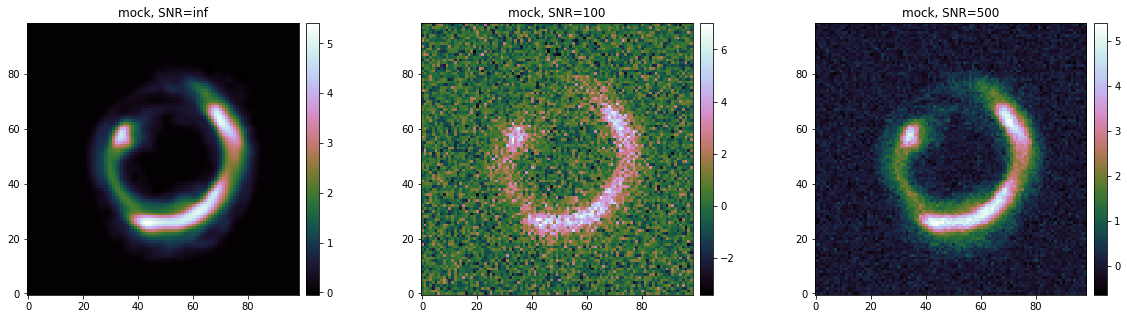

In [8]:
snr_range = [np.inf, 100, 500]
data_class_list = []
for snr in snr_range:
    sigma, noise = noise_with_SNR(snr, image_sim_no_noise)
    print(snr, sigma)
    kwargs_data['image_data'] = image_sim_no_noise + noise
    kwargs_data['background_rms'] = sigma
    kwargs_data['noise_map'] = sigma * np.ones_like(image_sim_no_noise)
    data_class_list.append(ImageData(**kwargs_data))

fig = plt.figure(figsize=(20, 5))
for i, dc in enumerate(data_class_list):
    ax = plt.subplot(1, len(data_class_list), i+1)
    ax.set_title("mock, SNR={}".format(snr_range[i]))
    im = ax.imshow(lin_scale(dc.data), origin='lower', cmap='cubehelix') #, vmin=0)
    nice_colorbar(im)
plt.show()

# remove 'infinite' SNR for the tests
snr_range = snr_range[1:]
data_class_list = data_class_list[1:]

## Prepare solver

In [9]:
source_model_class_sparsefit = LightModel(['STARLETS'])
kwargs_source_sparsefit  = [{'n_scales': 6}]  # starlet coeffs that are optimized for

kwargs_sparse_solver = {
    'lensing_operator': 'interpol',  # 'interpol' or 'simple'
    'subgrid_res_source': 2,
    'sparsity_prior_norm': 1,
    'max_threshold': 3,
    'num_iter_source': 20,
    'num_iter_weights': 3,
    'verbose': False,
    'show_steps': False,
}

Negative source pixels ? False (min = 0.00e+00)
Negative image pixels ? False (min = 1.54e-11)


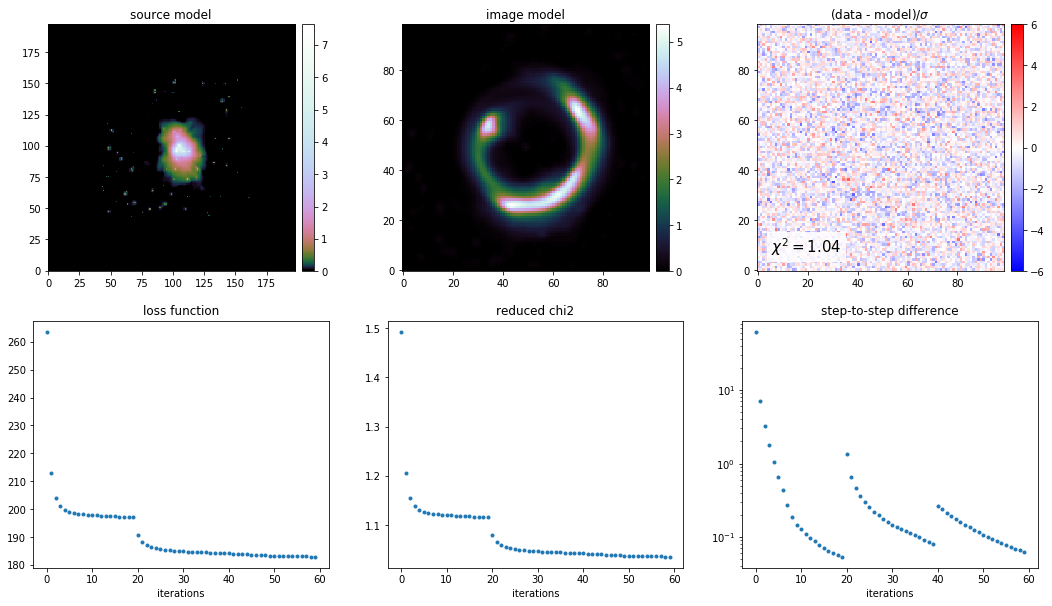

In [10]:
# test on the highest SNR to check for optimal settings
imageSparseFit_test = ImageSparseFit(data_class_list[-1], psf_class=psf_class, 
                                lens_model_class=lens_model_class,
                                source_model_class=source_model_class_sparsefit,
                                likelihood_mask=None,
                                kwargs_sparse_solver=kwargs_sparse_solver)


_, _, _ = imageSparseFit_test.image_sparse_solve(kwargs_lens=kwargs_truth['kwargs_lens'],
                                                 kwargs_source=kwargs_source_sparsefit)
imageSparseFit_test.sparseSolver.plot_results(cmap_1=log_cmap('cubehelix', 1e-2, 1),
                                              cmap_2='cubehelix')
plt.show()

## One-parameter free tests

In [11]:
def vary_one_parameter(param_name, param_range, kwargs_lens_truth, n_scales=6):
    fig, axes = plt.subplots(len(snr_range), 3, figsize=(16, 5*len(snr_range)), squeeze=False)
    
    if param_name in ['theta_E', 'gamma', 'e1', 'e2', 'center_x', 'center_y']:
        idx = lens_model_class.lens_model_list.index('SPEMD')
    elif ['gamma_ext', 'psi_ext', 'ra_0', 'dec_0']:
        idx = lens_model_class.lens_model_list.index('SHEAR_GAMMA_PSI')
    else:
        raise ValueError("Wrong parameter name ?")
    
    # plot true value
    true_value = kwargs_lens_truth[idx][param_name]
    
    # iterate over SNRs and parameter values
    for i, snr in enumerate(snr_range):
        axes[i, 0].set_title("varying : '{}' | SNR : {}".format(param_name, snr))
        axes[i, 0].set_xlabel("{}".format(param_name))
        axes[i, 0].set_ylabel("$\chi^2$")
        axes[i, 0].axvline(true_value, linestyle='--', color='black')
        axes[i, 1].set_ylabel("loss")
        axes[i, 0].set_xlabel("{}".format(param_name))
        axes[i, 1].axvline(true_value, linestyle='--', color='black')
        axes[i, 2].set_ylabel("regularization")
        axes[i, 0].set_xlabel("{}".format(param_name))
        axes[i, 2].axvline(true_value, linestyle='--', color='black')
        
        im_sim = ImageSparseFit(data_class_list[i], psf_class=psf_class, 
                                lens_model_class=lens_model_class,
                                source_model_class=LightModel(['STARLETS']),
                                likelihood_mask=None,
                                kwargs_sparse_solver=kwargs_sparse_solver)
        
        metrics = {'image_chi2': [], 'loss': [], 'reg': []}
        
        for param_value in tqdm.tqdm(param_range):
            kwargs_source_var = [{'n_scales': n_scales}]
            kwargs_lens_var = copy.deepcopy(kwargs_lens_truth)
            kwargs_lens_var[idx][param_name] = param_value
            #print(param_name, param_value, kwargs_lens_var)
            try:
                model_fit, model_fit_error, param_fit \
                    = im_sim.image_sparse_solve(kwargs_lens=kwargs_lens_var, 
                                                kwargs_source=kwargs_source_var)
            except Exception as e:
                print(e)
                metrics['image_chi2'].append(np.nan)
                metrics['loss'].append(np.nan)
                metrics['reg'].append(np.nan)
            else:
                S = im_sim.sparseSolver.source_model
                metrics['image_chi2'].append(im_sim.sparseSolver.best_fit_reduced_chi2)
                metrics['loss'].append(im_sim.sparseSolver.loss(S=S))
                metrics['reg'].append(im_sim.sparseSolver.regularization(S=S))

        axes[i, 0].plot(param_range, metrics['image_chi2'], linestyle='-')
        axes[i, 1].plot(param_range, metrics['loss'], linestyle='-')
        axes[i, 2].plot(param_range, metrics['reg'], linestyle='-')
        #axes[i, 2].legend()
    return fig, metrics


### Vary projected mass slope

  0%|          | 0/50 [00:00<?, ?it/s]

IndexError raised during construction of lens mapping : index 39313 is out of bounds for axis 0 with size 39204
with kwargs_lens: [{'theta_E': 1.8, 'gamma': 2.263265306122449, 'center_x': 0, 'center_y': 0, 'e1': 0.1, 'e2': -0.2}, {'gamma_ext': 0.02, 'psi_ext': 0.5, 'ra_0': 0, 'dec_0': 0}]
and kwargs_special: None
IndexError raised during construction of lens mapping : index 39313 is out of bounds for axis 0 with size 39204
with kwargs_lens: [{'theta_E': 1.8, 'gamma': 2.2755102040816326, 'center_x': 0, 'center_y': 0, 'e1': 0.1, 'e2': -0.2}, {'gamma_ext': 0.02, 'psi_ext': 0.5, 'ra_0': 0, 'dec_0': 0}]
and kwargs_special: None
IndexError raised during construction of lens mapping : index 39313 is out of bounds for axis 0 with size 39204
with kwargs_lens: [{'theta_E': 1.8, 'gamma': 2.2877551020408164, 'center_x': 0, 'center_y': 0, 'e1': 0.1, 'e2': -0.2}, {'gamma_ext': 0.02, 'psi_ext': 0.5, 'ra_0': 0, 'dec_0': 0}]
and kwargs_special: None
IndexError raised during construction of lens mapping

100%|██████████| 50/50 [00:49<00:00,  1.02it/s]


IndexError raised during construction of lens mapping : index 39313 is out of bounds for axis 0 with size 39204
with kwargs_lens: [{'theta_E': 1.8, 'gamma': 2.263265306122449, 'center_x': 0, 'center_y': 0, 'e1': 0.1, 'e2': -0.2}, {'gamma_ext': 0.02, 'psi_ext': 0.5, 'ra_0': 0, 'dec_0': 0}]
and kwargs_special: None
IndexError raised during construction of lens mapping : index 39313 is out of bounds for axis 0 with size 39204
with kwargs_lens: [{'theta_E': 1.8, 'gamma': 2.2755102040816326, 'center_x': 0, 'center_y': 0, 'e1': 0.1, 'e2': -0.2}, {'gamma_ext': 0.02, 'psi_ext': 0.5, 'ra_0': 0, 'dec_0': 0}]
and kwargs_special: None
IndexError raised during construction of lens mapping : index 39313 is out of bounds for axis 0 with size 39204
with kwargs_lens: [{'theta_E': 1.8, 'gamma': 2.2877551020408164, 'center_x': 0, 'center_y': 0, 'e1': 0.1, 'e2': -0.2}, {'gamma_ext': 0.02, 'psi_ext': 0.5, 'ra_0': 0, 'dec_0': 0}]
and kwargs_special: None
IndexError raised during construction of lens mapping

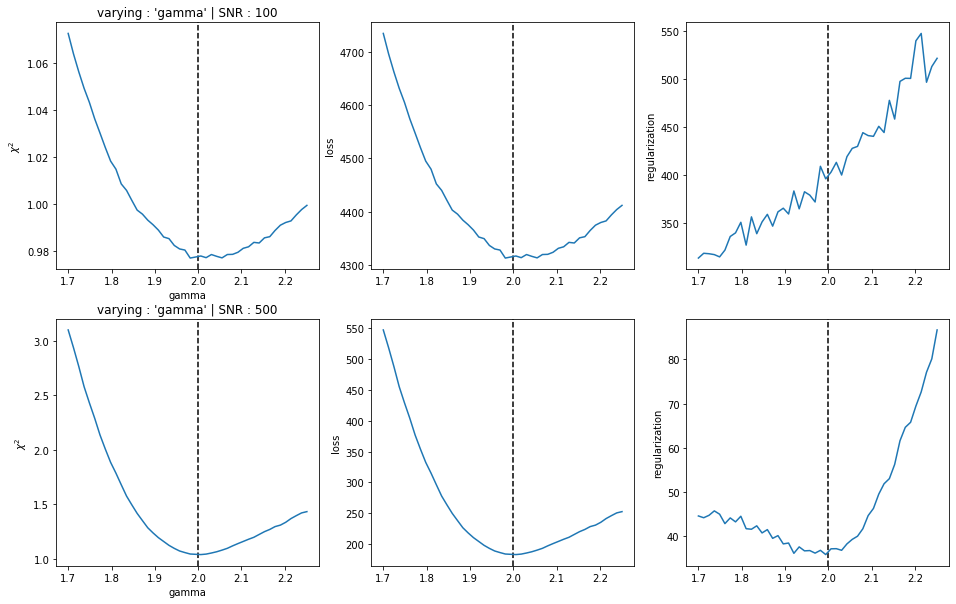

In [12]:
fig, _ = vary_one_parameter('gamma', np.linspace(1.7, 2.3, n_points), kwargs_truth['kwargs_lens'])
plt.show()

### Vary Einstein radius

100%|██████████| 50/50 [01:42<00:00,  2.04s/it]


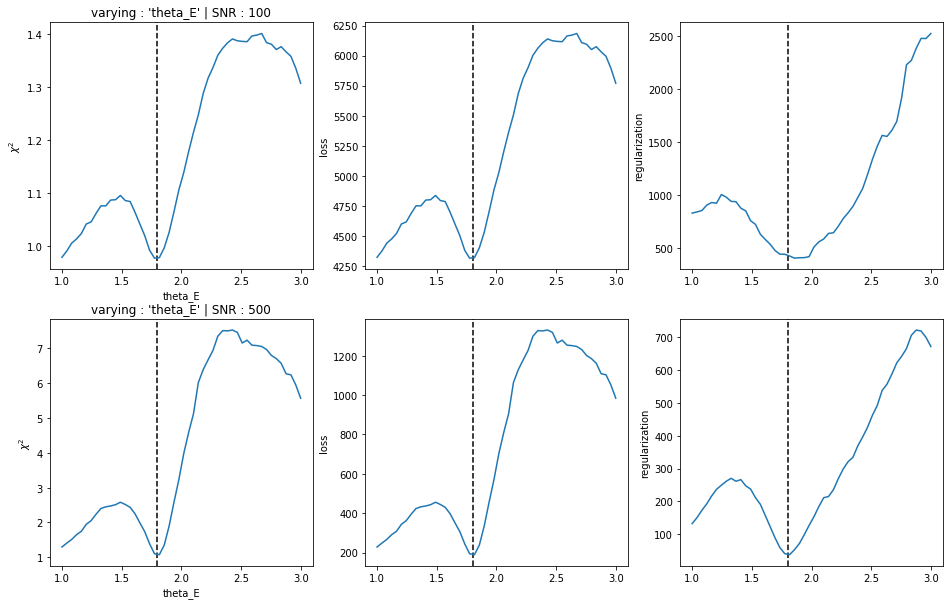

In [13]:
fig, _ = vary_one_parameter('theta_E', np.linspace(1, 3, n_points), kwargs_truth['kwargs_lens'])
plt.show()

### Vary ellipticities

100%|██████████| 50/50 [00:57<00:00,  1.17s/it]


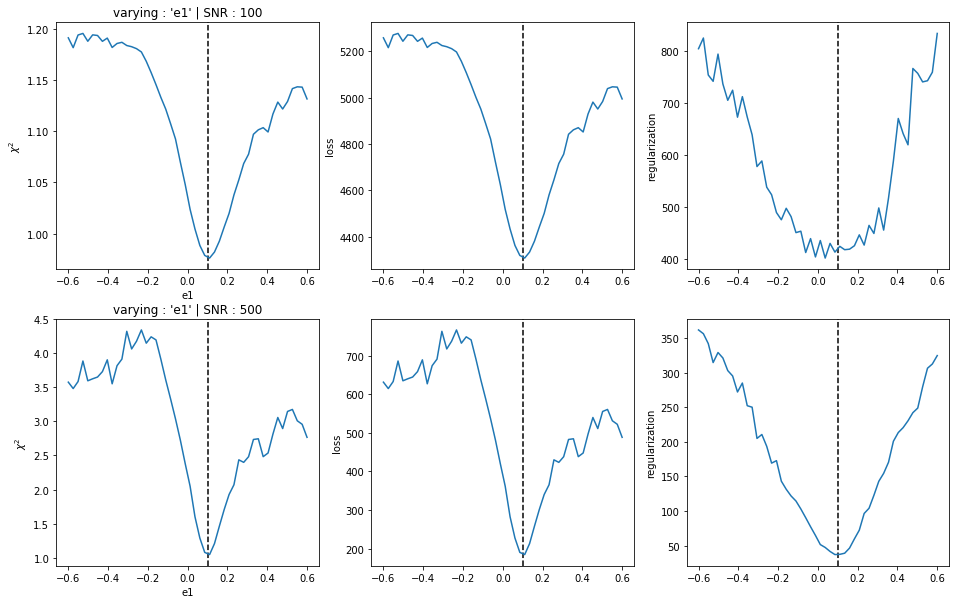

100%|██████████| 50/50 [00:49<00:00,  1.06s/it]


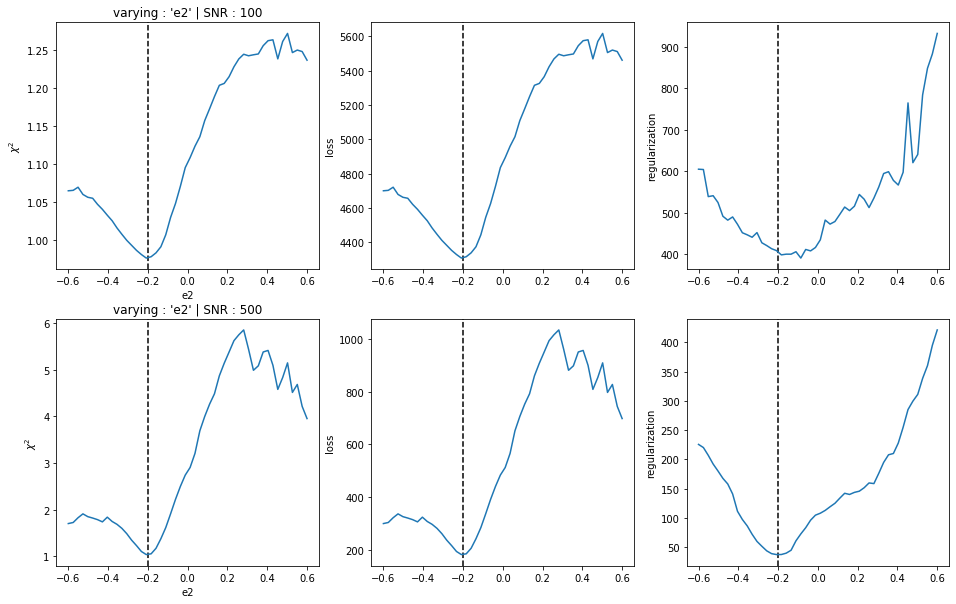

In [14]:
fig, _ = vary_one_parameter('e1', np.linspace(-0.6, 0.6, n_points), kwargs_truth['kwargs_lens'])
plt.show()
fig, _ = vary_one_parameter('e2', np.linspace(-0.6, 0.6, n_points), kwargs_truth['kwargs_lens'])
plt.show()

### Vary centroid position

100%|██████████| 50/50 [00:49<00:00,  1.02it/s]


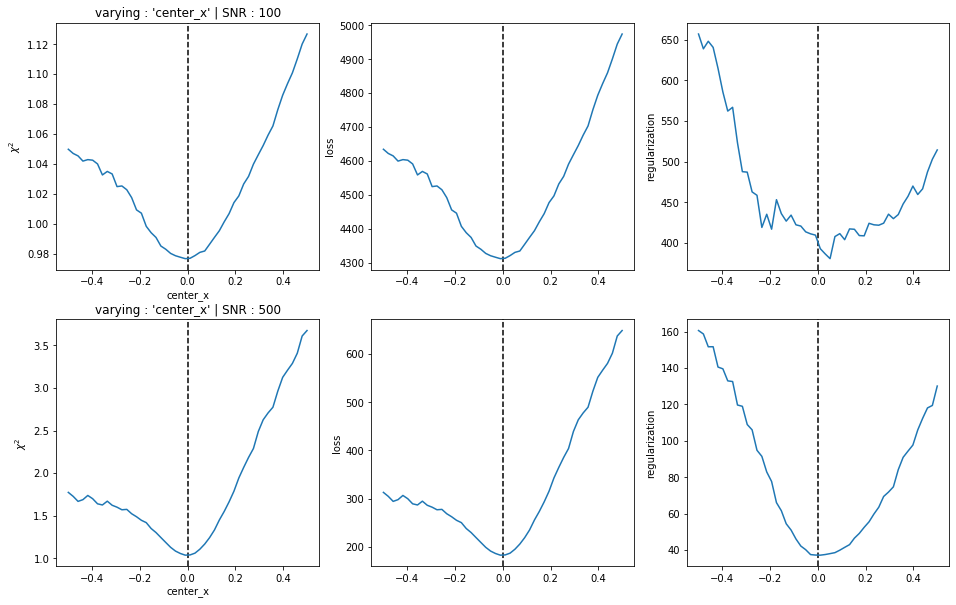

100%|██████████| 50/50 [00:49<00:00,  1.05s/it]


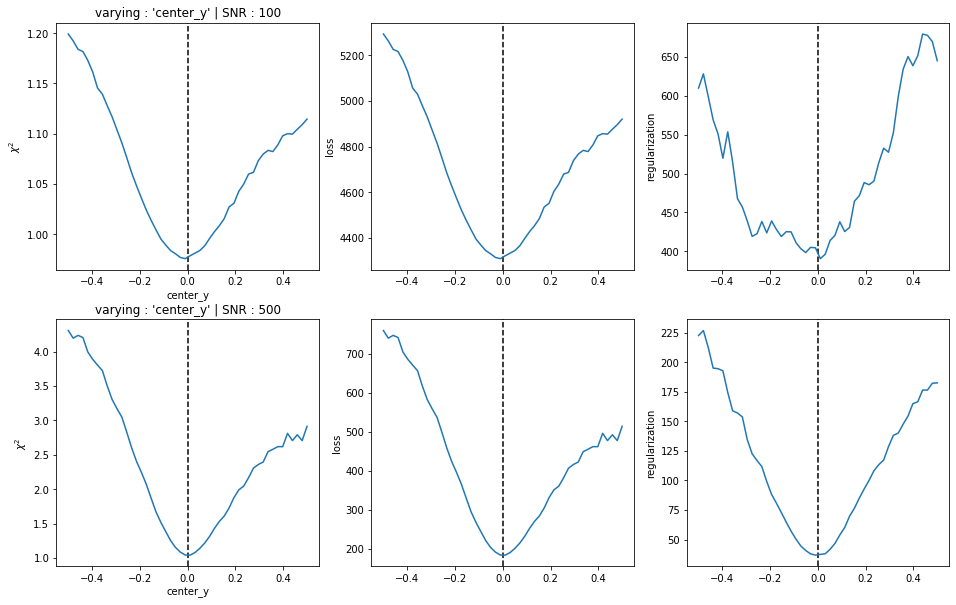

In [15]:
fig, _ = vary_one_parameter('center_x', np.linspace(-0.5, 0.5, n_points), kwargs_truth['kwargs_lens'])
plt.show()
fig, _ = vary_one_parameter('center_y', np.linspace(-0.5, 0.5, n_points), kwargs_truth['kwargs_lens'])
plt.show()

### Vary external shear

100%|██████████| 50/50 [00:49<00:00,  1.00s/it]


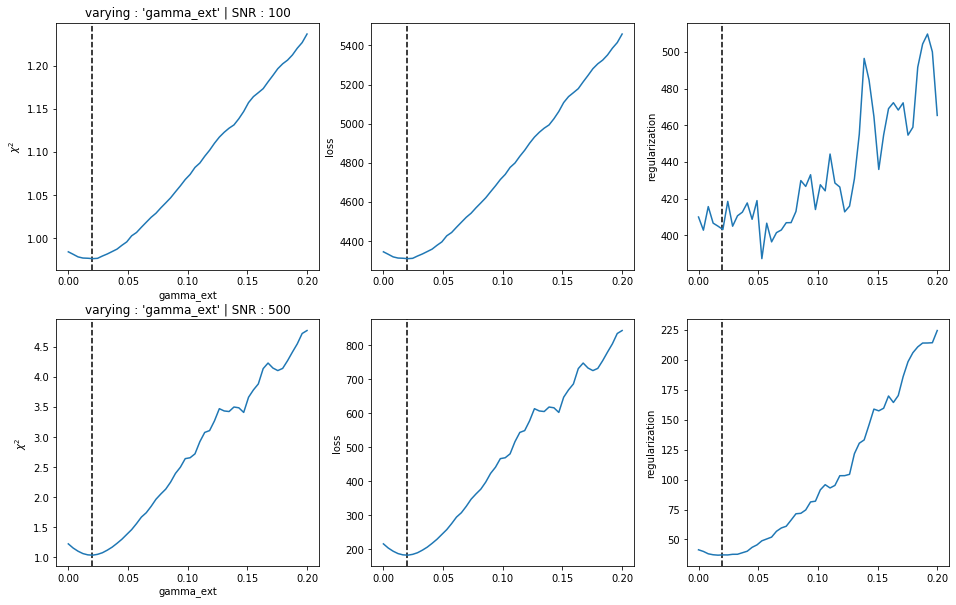

100%|██████████| 50/50 [00:49<00:00,  1.00s/it]


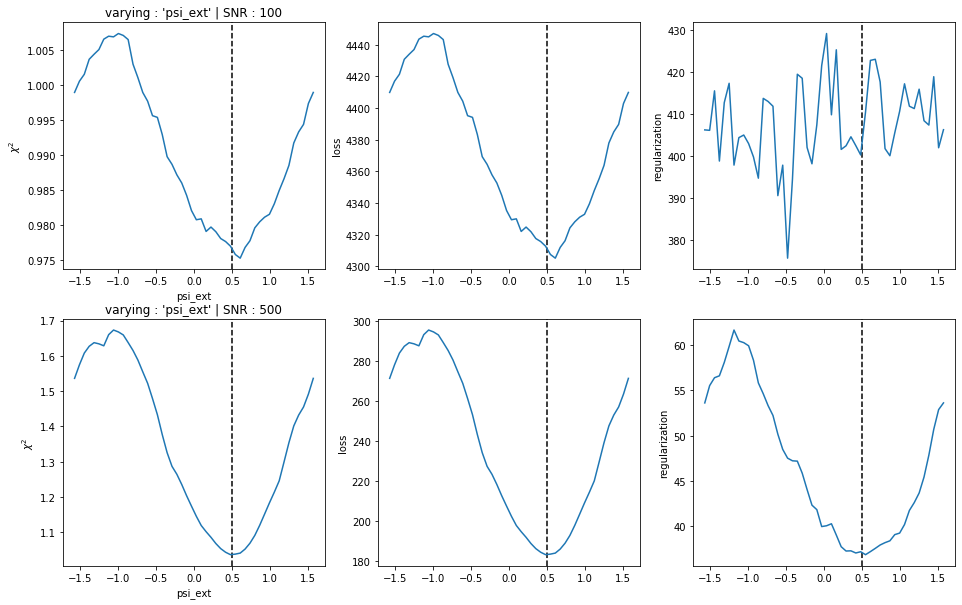

In [16]:
fig, _ = vary_one_parameter('gamma_ext', np.linspace(0, 0.2, n_points), kwargs_truth['kwargs_lens'])
plt.show()

fig, _ = vary_one_parameter('psi_ext', np.linspace(-np.pi/2, np.pi/2, n_points), kwargs_truth['kwargs_lens'])
plt.show()